In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
!pip install prophet

<ipython-input-8-fbba007da1cf>:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


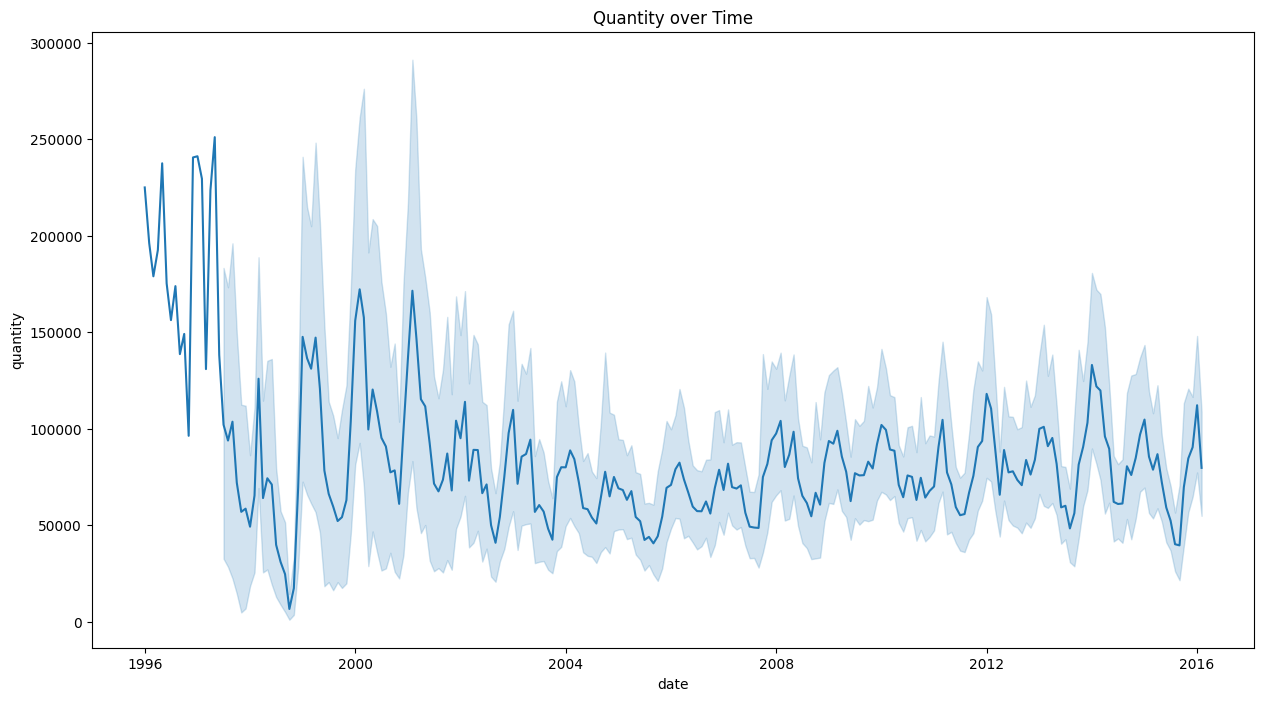

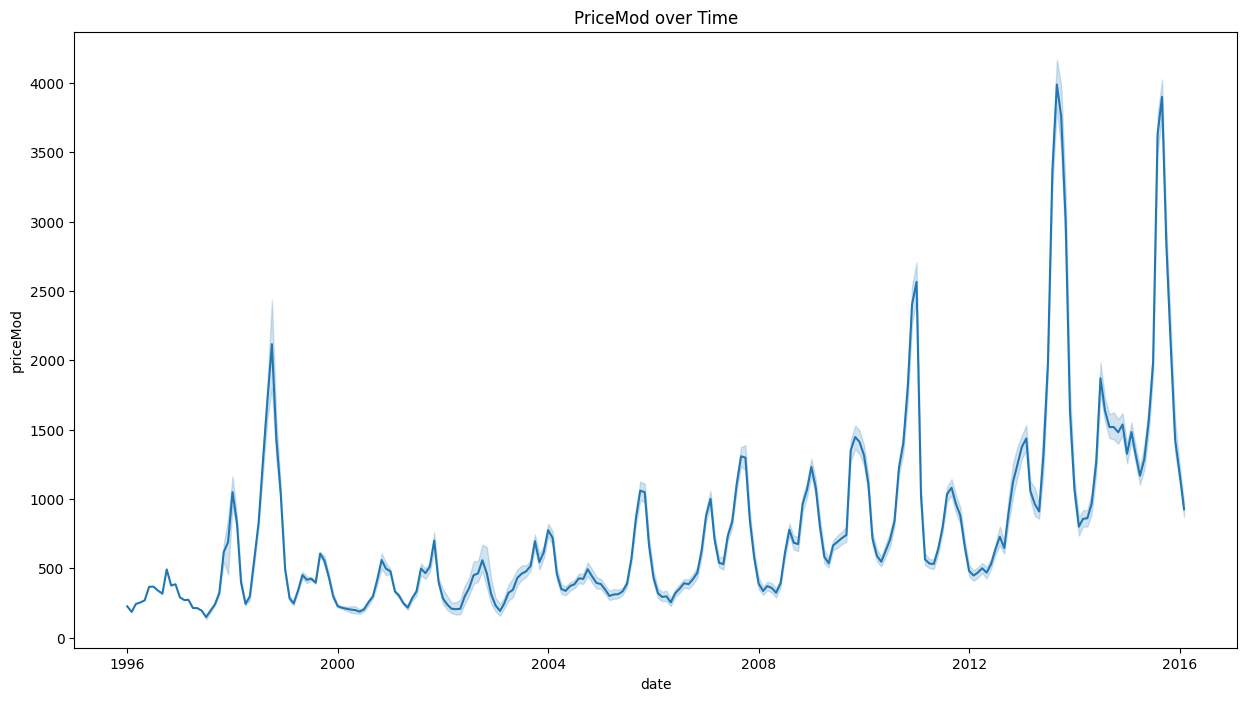

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

Best ARIMA MAE: 68584.43800326517
Best ARIMA MSE: 8556811970.532441
Best ARIMA RMSE: 92503.03762867705


DEBUG:cmdstanpy:input tempfile: /tmp/tmp093omdrk/nxhjnxe8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30680', 'data', 'file=/tmp/tmp093omdrk/mdsr25p2.json', 'init=/tmp/tmp093omdrk/nxhjnxe8.json', 'output', 'file=/tmp/tmp093omdrk/prophet_modeln87io9ax/prophet_model-20240531124842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:48:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:48:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 67562.77113087589
Prophet MSE: 10154785130.401354
Prophet RMSE: 100770.95380317363
64/64 [==============================] - 1s 5ms/step
LSTM MAE: 0.17788061910397887
LSTM MSE: 0.04555749398455431
LSTM RMSE: 0.2134420155090237


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

Best ARIMA MAE: 68584.43800326517
Best ARIMA MSE: 8556811970.532441
Best ARIMA RMSE: 92503.03762867705


['best_arima_model.pkl']

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.base import BaseEstimator, RegressorMixin

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/MarketPricePrediction.csv')

# Data Preprocessing
data.fillna(method='ffill', inplace=True)
label_encoder = LabelEncoder()
data['market'] = label_encoder.fit_transform(data['market'])
data['state'] = label_encoder.fit_transform(data['state'])
data['city'] = label_encoder.fit_transform(data['city'])
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(15, 8))
sns.lineplot(data=data, x='date', y='quantity')
plt.title('Quantity over Time')
plt.show()

plt.figure(figsize=(15, 8))
sns.lineplot(data=data, x='date', y='priceMod')
plt.title('PriceMod over Time')
plt.show()

# Feature Engineering
data['month'] = data.index.month
data['year'] = data.index.year
data['quarter'] = data.index.quarter
data['quantity_lag1'] = data['quantity'].shift(1)
data['priceMod_lag1'] = data['priceMod'].shift(1)
data['quantity_rolling_mean'] = data['quantity'].rolling(window=3).mean()
data['priceMod_rolling_mean'] = data['priceMod'].rolling(window=3).mean()
data.dropna(inplace=True)

# Split data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Custom ARIMA Wrapper
class ARIMAWrapped(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model_ = None

    def fit(self, X, y=None):
        self.model_ = ARIMA(X, order=self.order).fit()
        return self

    def predict(self, X):
        return self.model_.forecast(steps=len(X))

    def score(self, X, y):
        predictions = self.predict(X)
        return -mean_squared_error(y, predictions)

# Model Selection and Training
parameters = {'order': [(p, d, q) for p in range(1, 3) for d in range(0, 2) for q in range(1, 3)]}
arima_wrapped = ARIMAWrapped()
grid_search = GridSearchCV(estimator=arima_wrapped, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_data['quantity'].values.reshape(-1, 1), train_data['quantity'].values)

best_params = grid_search.best_params_
best_arima_model = ARIMAWrapped(order=best_params['order']).fit(train_data['quantity'].values.reshape(-1, 1))

# Evaluate the best model on the test data
arima_pred = best_arima_model.predict(test_data['quantity'].values.reshape(-1, 1))
print(f'Best ARIMA MAE: {mean_absolute_error(test_data["quantity"], arima_pred)}')
print(f'Best ARIMA MSE: {mean_squared_error(test_data["quantity"], arima_pred)}')
print(f'Best ARIMA RMSE: {np.sqrt(mean_squared_error(test_data["quantity"], arima_pred))}')

# Prophet Model
prophet_data = train_data.reset_index().rename(columns={'date': 'ds', 'quantity': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Forecast with Prophet
future = prophet_model.make_future_dataframe(periods=len(test_data))
forecast = prophet_model.predict(future)
prophet_pred = forecast['yhat'][-len(test_data):].values
print(f'Prophet MAE: {mean_absolute_error(test_data["quantity"], prophet_pred)}')
print(f'Prophet MSE: {mean_squared_error(test_data["quantity"], prophet_pred)}')
print(f'Prophet RMSE: {np.sqrt(mean_squared_error(test_data["quantity"], prophet_pred))}')

# LSTM Model
# Scaling data
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

# Reshape data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 3
X_train, y_train = create_dataset(scaled_train_data, time_step)
X_test, y_test = create_dataset(scaled_test_data, time_step)

# LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, batch_size=1, epochs=1)

# LSTM evaluation
lstm_pred = lstm_model.predict(X_test)
print(f'LSTM MAE: {mean_absolute_error(y_test, lstm_pred)}')
print(f'LSTM MSE: {mean_squared_error(y_test, lstm_pred)}')
print(f'LSTM RMSE: {np.sqrt(mean_squared_error(y_test, lstm_pred))}')

# Fine-tuning and Validation (Example for ARIMA)
# You can perform similar fine-tuning for Prophet and LSTM models
parameters = {'order': [(p, d, q) for p in range(1, 3) for d in range(0, 2) for q in range(1, 3)]}
grid_search = GridSearchCV(estimator=arima_wrapped, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_data['quantity'].values.reshape(-1, 1), train_data['quantity'].values)

best_params = grid_search.best_params_
best_arima_model = ARIMAWrapped(order=best_params['order']).fit(train_data['quantity'].values.reshape(-1, 1))

# Final evaluation on the best model
best_arima_pred = best_arima_model.predict(test_data['quantity'].values.reshape(-1, 1))
print(f'Best ARIMA MAE: {mean_absolute_error(test_data["quantity"], best_arima_pred)}')
print(f'Best ARIMA MSE: {mean_squared_error(test_data["quantity"], best_arima_pred)}')
print(f'Best ARIMA RMSE: {np.sqrt(mean_squared_error(test_data["quantity"], best_arima_pred))}')

# Deploying the Model
import joblib
joblib.dump(best_arima_model, 'best_arima_model.pkl')


In [5]:
# Prophet evaluation
future = prophet_model.make_future_dataframe(periods=len(test_data))
forecast = prophet_model.predict(future)
prophet_pred = forecast['yhat'][-len(test_data):].values
print(f'Prophet MAE: {mean_absolute_error(test_data["quantity"], prophet_pred)}')
print(f'Prophet MSE: {mean_squared_error(test_data["quantity"], prophet_pred)}')
print(f'Prophet RMSE: {np.sqrt(mean_squared_error(test_data["quantity"], prophet_pred))}')

Prophet MAE: 67562.77113087589
Prophet MSE: 10154785130.401354
Prophet RMSE: 100770.95380317363


In [4]:
# LSTM evaluation
lstm_pred = lstm_model.predict(X_test)
print(f'LSTM MAE: {mean_absolute_error(y_test, lstm_pred)}')
print(f'LSTM MSE: {mean_squared_error(y_test, lstm_pred)}')
print(f'LSTM RMSE: {np.sqrt(mean_squared_error(y_test, lstm_pred))}')

64/64 [==============================] - 0s 5ms/step
LSTM MAE: 0.15247391574193914
LSTM MSE: 0.033061490017046696
LSTM RMSE: 0.18182818818061927
